## Recurrent Neural Networks (RNNs)
### and Long Short-Term Memory (LSTM)

In [1]:
# !pip install scipy
# !pip install sklearn

In [80]:
from tensorflow import keras
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Objectives

* Use an RNN layer to featurize a sequence
* Describe an RNN cell's:
  * inputs
  * outputs
  * how to convert inputs to outputs
* Describe how an RNN can be used to featurize a sequence
  * full sequence
  * last state
* List a few other RNN cells (LSTM, GRU &c)
* Use RNNS for:
  * prediction the next item in a sequence
  * classifying sequences
  * doing regression on sequences
* Bonus if time:
  * EDA with RNNs
  * sequence generation

## Introduction

The neural networks we've talked about so far operate all at once. You have an input data point (or points) and the network, and the values propagate over the connections 

In this lesson we'll discuss **recurrent neural networks** (RNNs) which use time-series data as an input. The state of the network at a given point in time is based not just on the input layer at that time, but the state of the network from the previous point in time. So 

If a simple neural network looks like

<img src="img/simple-mlp.png" width=300>

A recurrent network looks like


<img src="img/rnn.png" width=300>

Where there's a connection from the hidden layer back to itself.

We can unroll this in time, showing each row as a separate time step.

<img src="img/rnn-unrolled-labeled.png" width=350>

Note that there are only three sets of weights: the vertical arrows, the horizontal arrows on the left, and the horizontal arrows on the right. To fit this model you fit those three sets of weights to the inputs $x_0$, $x_1$, $x_2$, and $x_3$ and minimize the loss between the output $\hat{x_4}$ and the label $x_4$.

Let' try this in `keras`!

Suppose we have some time-series data and we want to build a model so, given a bunch of points, we can predict the next point. For example:

In [3]:
n_pts = 500
t = np.linspace(0, 15 * 6, n_pts)

f_latent = lambda t: np.sin(t) + np.sin(2*t)

sin_t = f_latent(t)

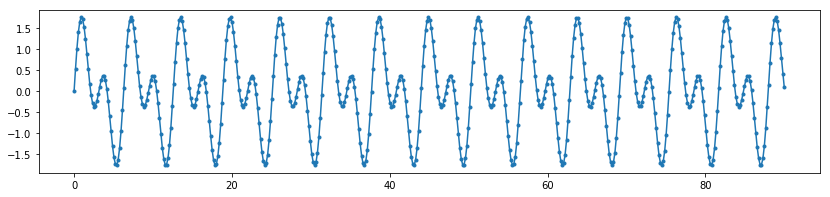

In [4]:
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(t, sin_t, '.-')

Except that's way to easy. Let's add some noise.

In [5]:
sigma = 0.5

sin_t_noisy = f_latent(t) + stats.norm(0, sigma).rvs(n_pts)

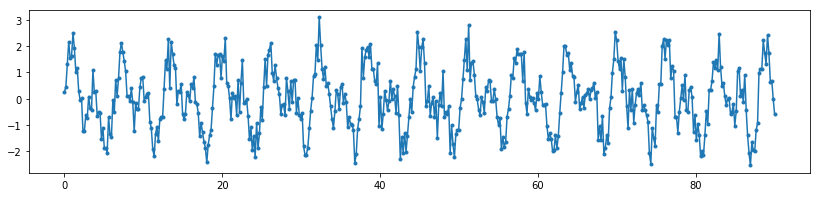

In [6]:
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(t, sin_t_noisy, '.-')

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First we'll write a function to consider every possible group of 50 values followed by one value (for the output) along our time-series data.

In [7]:
col_vec = lambda v: v[:,None] # convert 1d vector to 2d column vector

def split(ary, test_frac=0.3):
    n = int(len(ary)*test_frac)
    return ary[:-n], ary[-n:]

def windowize(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + col_vec( np.arange(n_predictions) )
    x = np.expand_dims( data[indices], axis=2 )
    return x, y

In [8]:
seq_train, seq_test = split(sin_t_noisy)

Here's the training and test chunks, the first 70% and last 30% respectively

Text(0.5, 1.0, 'train/test split of noisy signal')

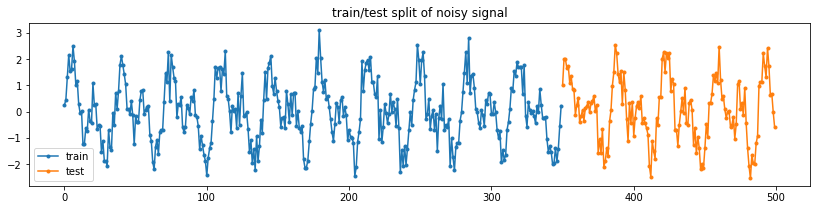

In [9]:
n_train, n_test = len(seq_train), len(seq_test)

fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(range(n_train), seq_train, ".-", label="train")
ax.plot(range(n_train,n_train+n_test), seq_test, ".-", label="test")
ax.legend()
ax.set_title("train/test split of noisy signal")


We can't just throw that into the model, though. As is usually the case with neural networks:
* the input needs to be a stack of consistently-sized tensors
* the output must be a label vector with the same length as the number of samples.

In this case, the "input sample" will be a 50-feature-wide chunk of signal, and the "label" will be the next item in the sequence.

In [10]:
seq_len = 50 #sometimes called "time steps"
X_train, y_train = windowize(seq_train, seq_len)
X_test, y_test = windowize(seq_test, seq_len)

In [11]:
X_train.shape # n_samples, sequence_length, n_channels

(300, 50, 1)

For example:

In [12]:
first_sample = X_train[0, :, 0] #first sample, all items, first channel (there's only one)

Text(0.5, 1.0, 'Sample sequence and target')

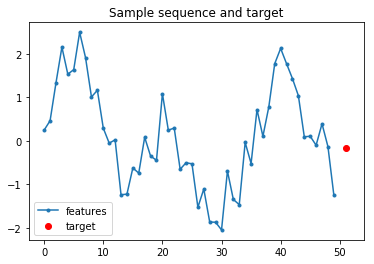

In [13]:
plt.plot( first_sample, ".-", label="features" )
plt.scatter( [seq_len+1],[y_train[0]], c="red", label="target" )
plt.legend()
plt.title("Sample sequence and target")

By chopping up the train and test subsegments into consistent-sized samples, we've turned this one signal into a great many samples:

In [14]:
print( "num training samples:", len(X_train) )
print( "num test samples:", len(X_test) )

num training samples: 300
num test samples: 100


As always we have the option of simply flattening the samples and training a random forest. Let's do that just to get a benchmark:

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

clf = RandomForestRegressor(n_estimators=100)
clf.fit( X_train.reshape(-1,50), y_train )
yhat = clf.predict( X_test.reshape(-1,50) )
print( mean_squared_error( y_test, yhat ) )

0.37370958713435437


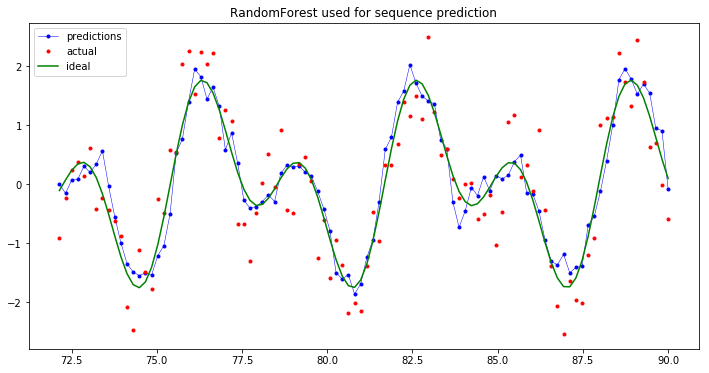

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], yhat, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.', label='actual')
ax.plot(t[-len(y_test):], f_latent(t[-len(y_test):]), 'g-', label='ideal')
ax.set_title("RandomForest used for sequence prediction")
ax.legend()

Instead, we'll train a model which is specifically designed for featurizing sequences:

Now we build our model. We'll put two RNN layers.

<img src="img/rnn-2-layer-unrolled.png" width=450>

Note that for the last layer we aren't going to fit all the outputs, but just the last one, so we set `return_sequences=False`. For the previous layer that feeds into that we need the output of each step, so `return_sequences=True`.

In [29]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(16, input_shape=(seq_len, 1), 
                                 return_sequences=False, 
                                 kernel_regularizer = keras.regularizers.l2(0.01)))
#model.add(keras.layers.SimpleRNN(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer=keras.optimizers.RMSprop(),#'rmsprop',
              loss='mse')

The input shape is `(seq_len, 1)` because we're training with `seq_len` prior time points and only have a single feature.

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 16)                288       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(X_train, y_train, batch_size=32, epochs=30, 
          validation_data=(X_test, y_test))

Train on 300 samples, validate on 100 samples
Epoch 1/30
300/300 [==============================] - 1s 2ms/sample - loss: 1.1931 - val_loss: 0.9879
Epoch 2/30
300/300 [==============================] - 0s 440us/sample - loss: 0.7533 - val_loss: 0.7233
Epoch 3/30
300/300 [==============================] - 0s 593us/sample - loss: 0.5923 - val_loss: 0.6125
Epoch 4/30
300/300 [==============================] - 0s 654us/sample - loss: 0.5156 - val_loss: 0.5551
Epoch 5/30
300/300 [==============================] - 0s 646us/sample - loss: 0.4677 - val_loss: 0.5043
Epoch 6/30
300/300 [==============================] - 0s 472us/sample - loss: 0.4388 - val_loss: 0.4792
Epoch 7/30
300/300 [==============================] - 0s 462us/sample - loss: 0.4124 - val_loss: 0.4593
Epoch 8/30
300/300 [==============================] - 0s 665us/sample - loss: 0.3975 - val_loss: 0.4495
Epoch 9/30
300/300 [==============================] - 0s 680us/sample - loss: 0.3919 - val_loss: 0.4422
Epoch 10/30
300/300 

#### Let's see what predictions we get.

In [32]:
yhat = model.predict(X_test)

print( "RNN output mse:", mean_squared_error( y_test, yhat ) )

RNN output mse: 0.3355119276645959


So we did worse than the random forest.

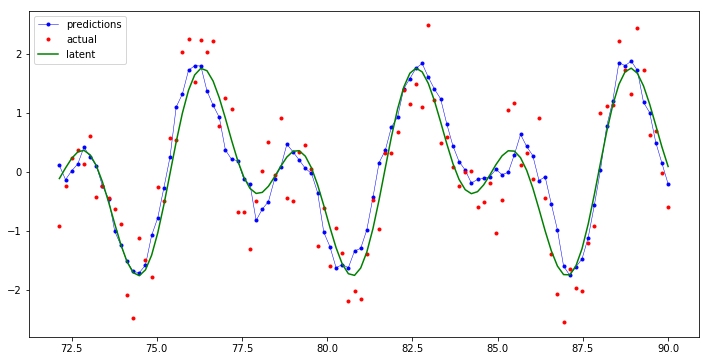

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], yhat, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.', label='actual')
ax.plot(t[-len(y_test):], f_latent(t[-len(y_test):]), 'g-', label='latent')
ax.legend()

That's not so great. Note, however, that the blue predictions do vary less than the red data points, so at least it averaged out some of the noise. 

## Diving into the RNN




The first layer of the sequential model is a "simple RNN layer". Let's get it and take it apart.

Each "Simple" (or "fully connected") RNN unit has two inputs: 
* One item in a sequence $x$
  * shape: `(1, n_channels)`
* Its internal state $h$
  * shape: `(n_neurons,)`

The unit is also parameterized by three matrices 
* Input matrix $U$ - dense connection from input to the hidden state
  * shape: `(n_channels, n_neurons)`
* Recurrent matrix $V$ - dense connection from the hidden state to itself
  * shape: `(n_neurons, n_neurons)`
* Bias vector $b$.
  * shape: `(n_neurons,)`

These matrices are discovered during model training.

The Simple RNN has one output:

* $h' = \phi( Ux + Vh + b)$ (same shape as h)

(where $\phi$ is the activation function; `tanh` is standard)

As implemented in various software packages, these matrices may appear transposed.

In [34]:
rnn, full_connection = model.layers
rnn

This will take a dataset convert into the activations of all neurons in the RNN unit for the length if the input sequence.

In [37]:
#a_sample = X_test[0:1].astype(np.float32)

#rnn_output = rnn( a_sample ).numpy()

In [38]:
#feel free to confirm for yourself that the shapes make sense
U, V, b = rnn.get_weights() 

Let's actually step through this RNN unit reacting to an input

The first sequence in the training set:

In [51]:
#x0 = X_test[0].astype(np.float32)
#del x0

In [59]:
# the inputs are h and x
h = np.zeros(16) # the initial internal state is zeroed out
x = sin_t_noisy[0:1] # first item in the first sequence

raw_activation = V@h + x@U + b

h_prime = keras.activations.tanh( raw_activation ).numpy()

Thus we converted the input sequence item into an output item, and transmuted the internal state.

In [60]:
h_prime

array([-0.02815801,  0.13133217,  0.12629812,  0.02490674, -0.00169485,
       -0.13220271,  0.10925678, -0.0546605 ,  0.06656009,  0.11916125,
        0.00598139, -0.11307339,  0.05305818,  0.04975215,  0.05536761,
        0.12765468])

We could do this over and over, and it would simply return the record of the activation state of each neuron in the RNN unit:

In [61]:
activation_states = []

for x_i in sin_t_noisy:
    raw_activation = V@h + [x_i]@U + b
    h = keras.activations.tanh( raw_activation ).numpy()
    activation_states.append( h )

activation_states = np.stack( activation_states )

Text(0, 0.5, 'neuron')

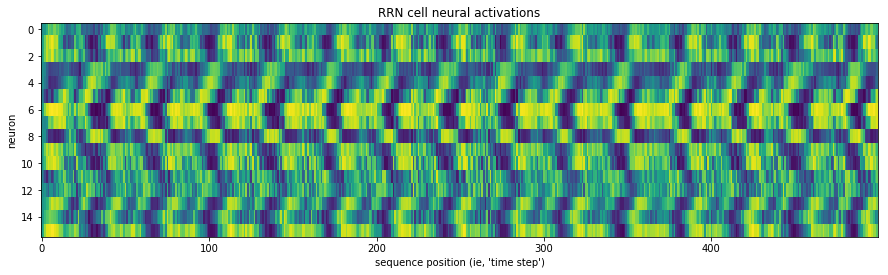

In [73]:
fig, ax = plt.subplots(figsize=(15,10))

ax.imshow( activation_states.T, aspect=8.0 )
ax.set_title( "RRN cell neural activations" )
ax.set_xlabel( "sequence position (ie, 'time step')")
ax.set_ylabel( "neuron" )

Here's the activations of the first four neurons, just to show you the same data from a different direction.

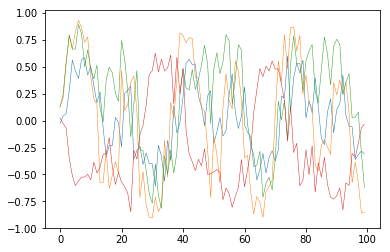

In [75]:
for i in range(4):
    plt.plot( activation_states.T[i,0:100], lw=-.5 )

This RNN has appeared to learn to take a crude sort of spectrum decomposition, which is **extremely amazing**.

In [76]:
W, b = model.layers[1].get_weights()

A full connection between the 1-d output state and a scalar output can be stored as a 1d vector; the "prediction" corresponding to each RNN state is simply a weighted sum of the RNN cell's internal state.

In [77]:
W.T

array([[ 0.06200808, -0.17163965, -0.22889595, -0.32998633,  0.5442107 ,
        -0.54749995,  0.05440511,  0.31627533,  0.5822735 , -0.2992648 ,
        -0.44736138, -0.47987515,  0.49459633, -0.32303086, -0.31481016,
         0.21539225]], dtype=float32)

Text(0.5, 1.0, 'Sequence-to-sequence conversion for first sample in testing set')

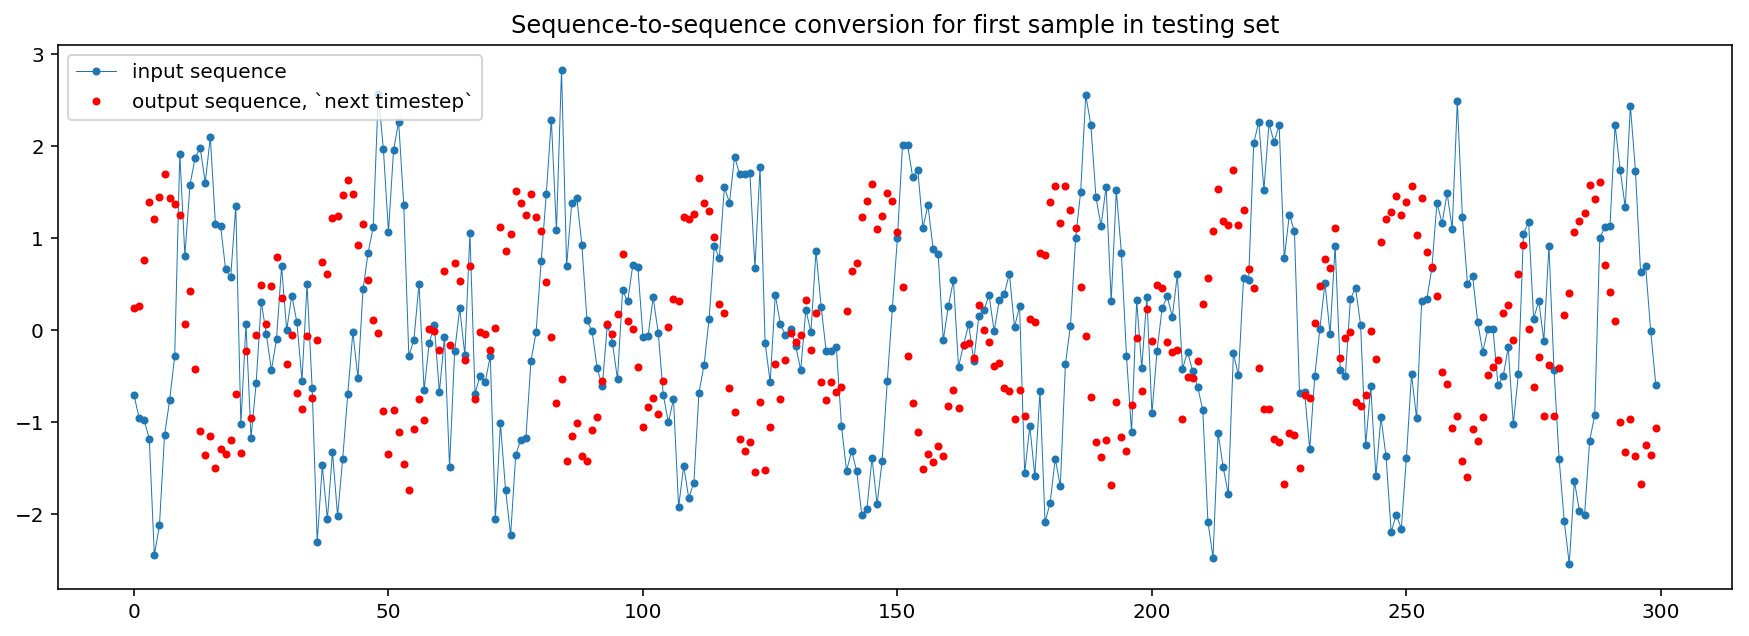

In [87]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot( sin_t_noisy[-300:], ".-", label="input sequence", lw=0.5 )
ax.plot( ( activation_states @ W + b ).flatten()[-300:], ".", 
           c="red", label="output sequence, `next timestep`" )
ax.legend()
ax.set_title("Sequence-to-sequence conversion for first sample in testing set")


## Long-Short-Term-Memory ("LSTM") units

One of the difficulties with traditional RNNs is what's called the "vanishing gradients problem." For neural networks (this is 50 levels deep!) the effect of the input at the beginning exponentially shrinks with the depth of the network. This makes it very hard to remember details from the disThe the signal from each successively earlier point is typically smaller (or maybe larger) than the previous is that while they can "remember" what happened recently, 

There are other architectures of RNNs that will do a better job. One is a Long Short Term Memory (LSTM) network; a good post detailing them is at [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [127]:
model = keras.Sequential()
model.add(keras.layers.LSTM(16, input_shape=(seq_len, 1), return_sequences=True))
model.add(keras.layers.Lambda(lambda x:x[:,-1,:])) #just get the last state
#model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mse')

In [128]:
model.fit(X_train, y_train, batch_size=32, epochs=100, 
          validation_data=(X_test, y_test))

Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 [==============================] - 1s 3ms/sample - loss: 1.0526 - val_loss: 1.1353
Epoch 2/100
300/300 [==============================] - 0s 750us/sample - loss: 0.9377 - val_loss: 1.0333
Epoch 3/100
300/300 [==============================] - 0s 865us/sample - loss: 0.8511 - val_loss: 0.9354
Epoch 4/100
300/300 [==============================] - 0s 893us/sample - loss: 0.7650 - val_loss: 0.8406
Epoch 5/100
300/300 [==============================] - 0s 1ms/sample - loss: 0.6811 - val_loss: 0.7504
Epoch 6/100
300/300 [==============================] - 0s 825us/sample - loss: 0.6056 - val_loss: 0.6743
Epoch 7/100
300/300 [==============================] - 0s 765us/sample - loss: 0.5426 - val_loss: 0.6158
Epoch 8/100
300/300 [==============================] - 0s 872us/sample - loss: 0.4964 - val_loss: 0.5666
Epoch 9/100
300/300 [==============================] - 0s 1ms/sample - loss: 0.4600 - val_loss: 0.5325
Epoch 10/100
30

300/300 [==============================] - 0s 930us/sample - loss: 0.2468 - val_loss: 0.2992
Epoch 79/100
300/300 [==============================] - 0s 1ms/sample - loss: 0.2436 - val_loss: 0.2893
Epoch 80/100
300/300 [==============================] - 0s 959us/sample - loss: 0.2447 - val_loss: 0.2900
Epoch 81/100
300/300 [==============================] - 0s 1ms/sample - loss: 0.2464 - val_loss: 0.2912
Epoch 82/100
300/300 [==============================] - 0s 942us/sample - loss: 0.2438 - val_loss: 0.2999
Epoch 83/100
300/300 [==============================] - 0s 1ms/sample - loss: 0.2418 - val_loss: 0.3007
Epoch 84/100
300/300 [==============================] - 0s 1ms/sample - loss: 0.2456 - val_loss: 0.2918
Epoch 85/100
300/300 [==============================] - 0s 1ms/sample - loss: 0.2435 - val_loss: 0.2916
Epoch 86/100
300/300 [==============================] - 0s 1ms/sample - loss: 0.2438 - val_loss: 0.2986
Epoch 87/100
300/300 [==============================] - 0s 1ms/sample -

In [129]:
yhat = model.predict(X_test)
mean_squared_error( y_test, yhat )

0.29109402663725636

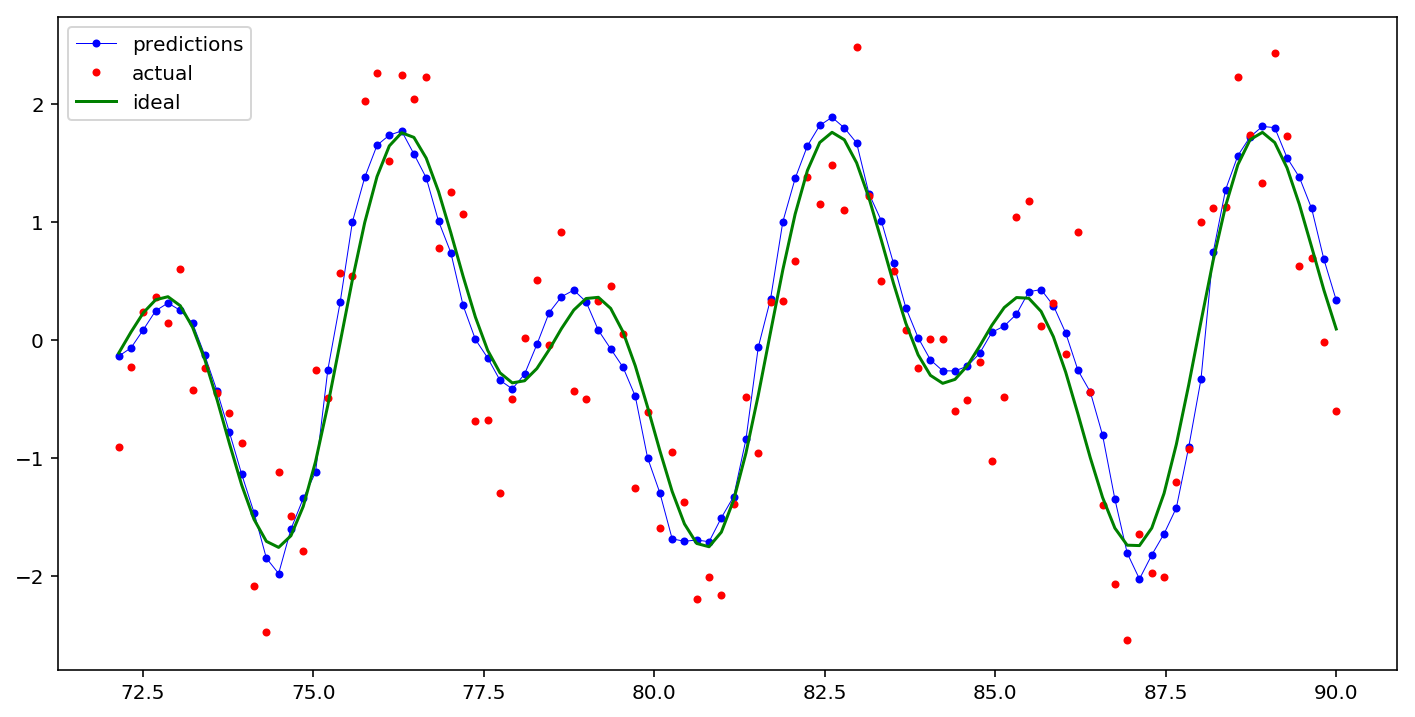

In [130]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], yhat, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.', label='actual')
ax.plot(t[-len(y_test):], f_latent(t[-len(y_test):]), 'g-', label='ideal')
ax.legend()

This does slightly better than the RandomForest sequence predictor. Also, it makes smoother predictions.

I won't go diving into the implementation of LSTM units - it's a lot more complicated than fully-connected RNN units - but each LSTM cell still has a number of neurons (specified in the Keras sequence definition) and the output of the first layer is the trace of the activations of all neurons.

### LSTM hidden state

LSTM cells have hidden state too. The hidden state of the last stage in the sequence is usually the layer output, but we can take a look at the neural evolution over the sequence...

Text(0.5, 1.0, 'LSTM hidden state evolution over course of single sample')

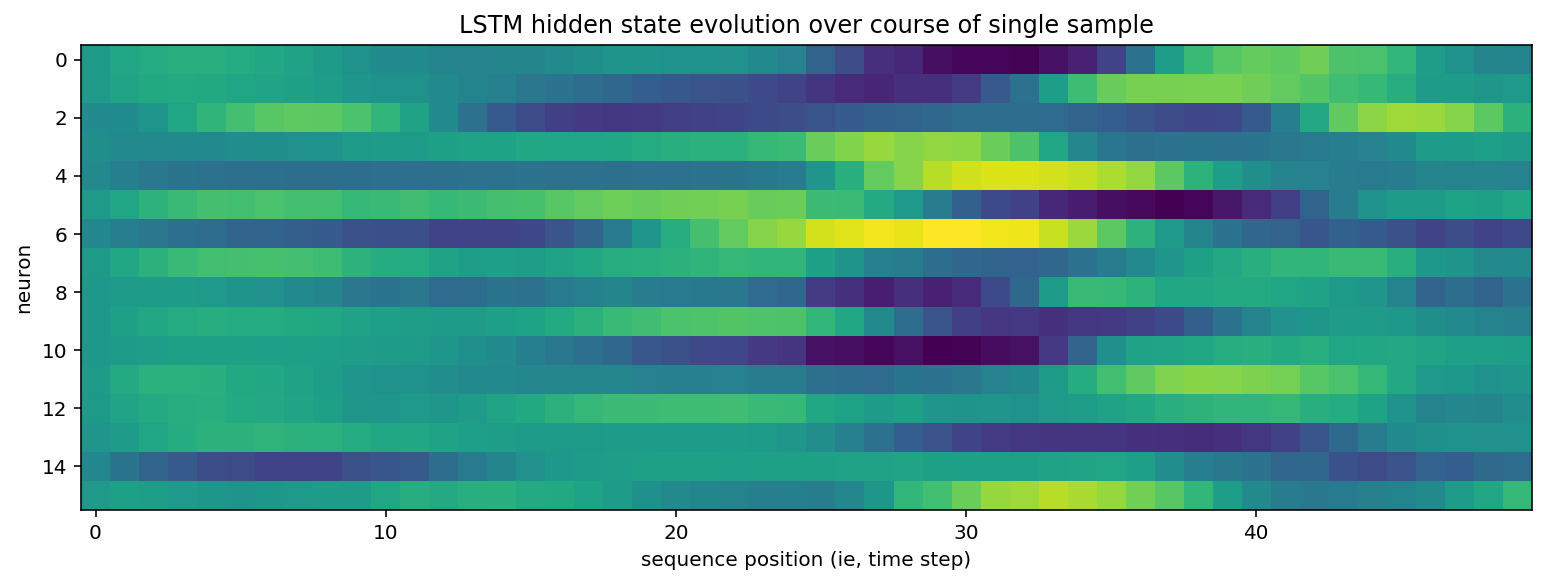

In [145]:
activation_states = model.layers[0]( X_test[0:1].astype(np.float32) ).numpy()[0].T

fig, ax = plt.subplots(figsize=(13,5))
ax.imshow( activation_states )
ax.set_xlabel("sequence position (ie, time step)")
ax.set_ylabel("neuron")
ax.set_title("LSTM hidden state evolution over course of single sample")

In [146]:
W, b = model.layers[-1].get_weights()

In [147]:
activation_states.shape, W.shape, b.shape

((16, 50), (16, 1), (1,))

In [153]:
pred_sequence = 

Text(0.5, 0, 'sequence index (ie timestep)')

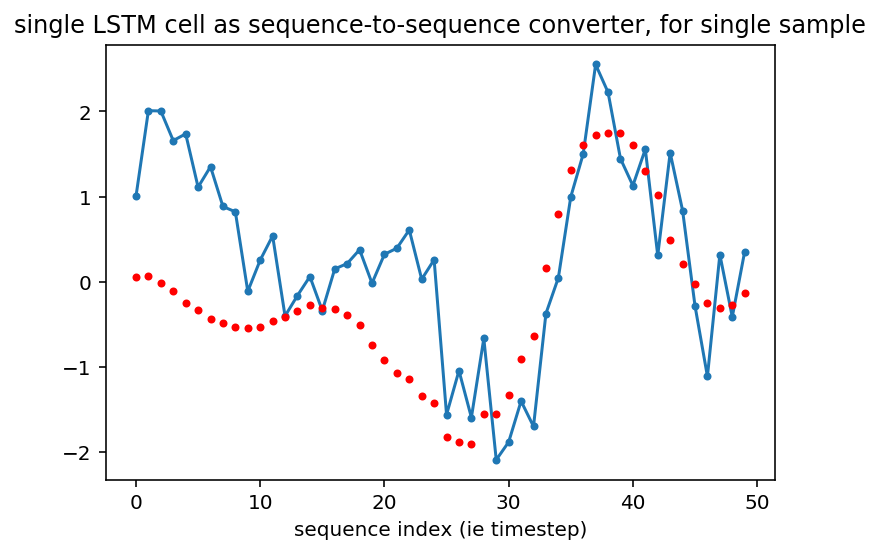

In [166]:
plt.plot( X_test[0:1].flatten(), ".-", label="input sequence" )
plt.plot( (activation_states.T @ W + b).flatten(), ".", 
         c="red", label="output sequence `next timestep`" )
plt.title("single LSTM cell as sequence-to-sequence converter, for single sample")
plt.xlabel("sequence index (ie timestep)")

# Classification

RNNs can also be used for classification. Rather than predicting the next step after a sequence as the output, we predict a class (or rather, a probability). Let's try two sequences, sine waves of slightly difference frequencies.

In [59]:
n_pts = 500
t = np.linspace(0, 15 * 6, n_pts)
sin_11t_noisy = np.sin(1.1*t) + stats.norm(0, 0.5).rvs(n_pts)
sin_t_noisy = np.sin(t) + stats.norm(0, 0.5).rvs(n_pts)

We don't care about the next value any more.

In [60]:
(X_train1, _), (X_test1, _) = [windowize(x, 50) for x in split(sin_t_noisy)]
(X_train2, _), (X_test2, _) = [windowize(x, 50) for x in split(sin_11t_noisy)]

Instead, the `y`s are the labels of the class.

In [61]:
X_train = np.concatenate([X_train1, X_train2])
X_test = np.concatenate([X_test1, X_test2])
y_train = np.concatenate([np.zeros(X_train1.shape[0]), np.ones(X_train2.shape[0])])
y_test = np.concatenate([np.zeros(X_test1.shape[0]), np.ones(X_test2.shape[0])])

We'll use a sigmoid activation at the end.

In [62]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(32, input_shape=(seq_len, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(seq_len, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',metrics=["accuracy"])

In [63]:
y_train.shape, y_test.shape

((600,), (200,))

In [64]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Train on 600 samples, validate on 200 samples
Epoch 1/10
600/600 [==============================] - 3s 5ms/sample - loss: 0.6947 - accuracy: 0.5200 - val_loss: 0.6879 - val_accuracy: 0.5750
Epoch 2/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.6601 - accuracy: 0.6233 - val_loss: 0.6329 - val_accuracy: 0.7000
Epoch 3/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.5466 - accuracy: 0.7367 - val_loss: 0.5545 - val_accuracy: 0.7550
Epoch 4/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.4407 - accuracy: 0.8267 - val_loss: 0.4857 - val_accuracy: 0.6850
Epoch 5/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.4371 - accuracy: 0.7933 - val_loss: 0.6503 - val_accuracy: 0.7200
Epoch 6/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.3798 - accuracy: 0.8233 - val_loss: 0.4265 - val_accuracy: 0.8350
Epoch 7/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.2968 - accur

In [65]:
yhat = model.predict(X_test)[:,0]

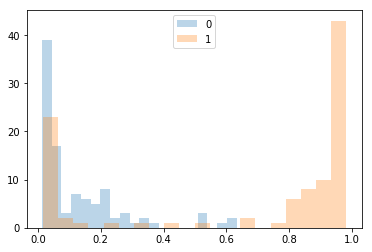

In [66]:
fix, ax = plt.subplots()
ax.hist(yhat[y_test == 0], alpha=0.3, bins=20, label="0")
ax.hist(yhat[y_test == 1], alpha=0.3, bins=20, label="1")
ax.legend()

# Regression

Maybe we could use an RNN to figure out the frequency of a signal. Here we'll just create a lot of sequences (with noise), each with a different frequency and starting point. 

In [67]:
n_pts = 50
n_sequences = 1000
length = 10  # length of each sequence
xpts = np.linspace(0, length, n_pts)
offsets = stats.uniform(0, 2*np.pi).rvs(n_sequences)[:, None]
freqs = stats.uniform(1,4).rvs(n_sequences)[:, None]
signals = np.sin(xpts*freqs + offsets) + stats.norm(0, 0.3).rvs((n_sequences, n_pts))

Let's look at some of the sequences.

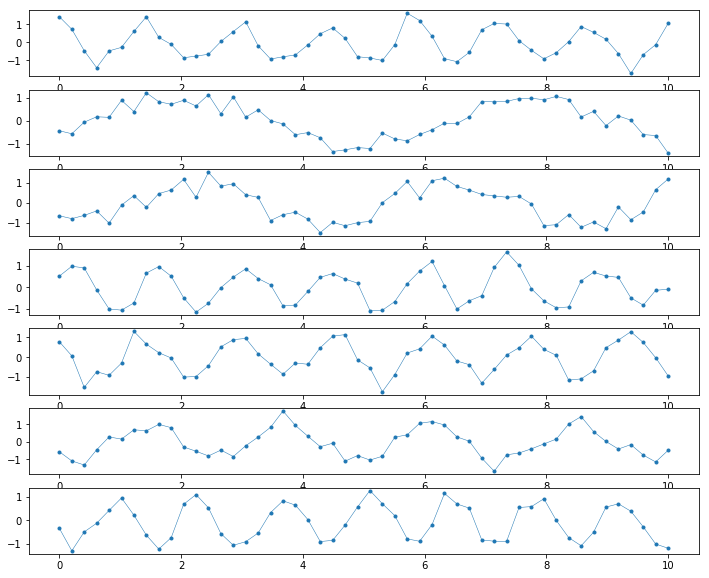

In [68]:
fig, axs = plt.subplots(7, 1, figsize=(12,10))
for i, ax in zip(range(7), axs):
    ax.plot(xpts, signals[i], '.-', lw=0.5)


In [69]:
model = keras.Sequential()
#model.add(keras.layers.LSTM(32, input_shape=(n_pts, 1), return_sequences=True))
#model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.LSTM(32, input_shape=(n_pts, 1), return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mse')

In [70]:
X_train, X_test, y_train, y_test = train_test_split(signals[:, :, None], freqs[:, 0])

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 50, 1), (250, 50, 1), (750,), (250,))

In [72]:
model.fit(X_train, y_train,  batch_size=32, epochs=20, 
          validation_data=(X_test, y_test))

Train on 750 samples, validate on 250 samples
Epoch 1/20
750/750 [==============================] - 1s 2ms/sample - loss: 5.5035 - val_loss: 1.4016
Epoch 2/20
750/750 [==============================] - 1s 844us/sample - loss: 1.3057 - val_loss: 1.3582
Epoch 3/20
750/750 [==============================] - 1s 854us/sample - loss: 1.2688 - val_loss: 1.4123
Epoch 4/20
750/750 [==============================] - 1s 878us/sample - loss: 1.0472 - val_loss: 0.9406
Epoch 5/20
750/750 [==============================] - 1s 891us/sample - loss: 0.5794 - val_loss: 0.6579
Epoch 6/20
750/750 [==============================] - 1s 928us/sample - loss: 0.4519 - val_loss: 0.2607
Epoch 7/20
750/750 [==============================] - 1s 932us/sample - loss: 0.4253 - val_loss: 0.2626
Epoch 8/20
750/750 [==============================] - 1s 960us/sample - loss: 0.3842 - val_loss: 0.2945
Epoch 9/20
750/750 [==============================] - 1s 1ms/sample - loss: 0.3922 - val_loss: 0.2407
Epoch 10/20
750/750 [=

In [73]:
yhat = model.predict(X_test)

How did we do?

Text(0.5, 1.0, 'test value vs prediction')

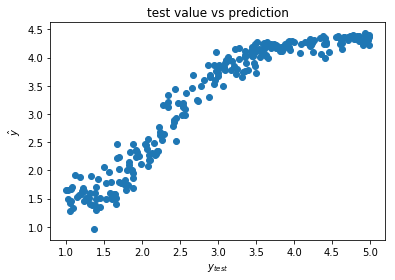

In [74]:
fig, ax = plt.subplots()
ax.scatter(y_test, yhat)
ax.set_xlabel("$y_{test}$")
ax.set_ylabel("$\hat{y}$")
ax.set_title("test value vs prediction")

## Super extra credit

If for some reason we still have a lot of time, which is impossible, check out [generating text with an RNN](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/text/text_generation.ipynb#scrollTo=AM2Uma_-yVIq).